## ESCAPE 4 JUNE 2022

### Lightning for all RHIs in southern cell scanned by PX1000

In [1]:
import matplotlib.pyplot as plt
import pyart
import numpy as np
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
from datetime import datetime, date, time, timedelta
import pyart.graph.cm as pcm
import warnings
warnings.filterwarnings("ignore")

from lmatools.coordinateSystems import RadarCoordinateSystem, GeographicSystem, TangentPlaneCartesianSystem, MapProjection


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


### [LMAinterceptRHI](https://github.com/jcssouza/LMAinterceptRHI)

In [2]:
import sys
sys.path.append("./LMAinterceptRHI/")
# Adapted functions from LMAinterceptRHI
from radarlma2local import geo_to_tps
from ortho_proj import rot_mat_lma, close_sources, closest_pt_radarloc
from radar_processing import r_z_centers_edges_mesh
from interp_funcs import centers_to_edges_1d, coords_2d

In [3]:
from shapely.geometry import Polygon, Point, MultiPoint

class RadarLMASubsetter:
    def __init__(self, radar, lma, sweep_id=0):
        self.radar = radar
        self.lma = lma
        
        # -- Get radar time
        d = date(int(radar.time['units'][14:18]),int(radar.time['units'][19:21]),int(radar.time['units'][22:24]))
        t = time(int(radar.time['units'][25:27]),int(radar.time['units'][28:30]),int(radar.time['units'][31:33]))
        self.radar_time = datetime.combine(d,t)
        
        print('Radar scan type: ' + radar.scan_type)
        print('Sweep: ', sweep_id+1, 'of', radar.nsweeps)
        print(self.radar_time)
        
        # -- Initialize coordinate systems
        ctrlat, ctrlon, ctralt = radar.latitude['data'][0], radar.longitude['data'][0], radar.altitude['data'][0]
        self.ctrlat, self.ctrlon, self.ctralt = ctrlat, ctrlon, ctralt
        self.geo = GeographicSystem()
        self.tps = TangentPlaneCartesianSystem(ctrlat, ctrlon, ctralt)
        self.rcs = RadarCoordinateSystem(ctrlat, ctrlon, ctralt)

    
        # -- Radar scan geometry: centers and edges of each gate
        RZ_centers, RZ_edges = r_z_centers_edges_mesh(radar, sweep_id)
        self.r_c = RZ_centers[:,:,0]
        self.z_c = RZ_centers[:,:,1]
        self.r_e = RZ_edges[:,:,0]
        self.z_e = RZ_edges[:,:,1]

        # Radar shape
        # -- To filter VHF sources out of the radar scan domain
        # --- Create the polygon: all ranges, lowest and highest elevation
        self.scan_poly = Polygon(np.append(
                np.append(RZ_edges[-1, :-1], RZ_edges[0, :-1], axis = 0), 
                RZ_edges[:, - 1], axis = 0))
        # scan_poly
        
    
    def lightning_within_time(self, seconds, max_alt=18e3, max_chi2=1.0, min_station=6):
        lma_data = self.lma
        radar_time = self.radar_time
        
        # Filter time and altitude
        sources = (lma_data.event_altitude < max_alt) & (abs( (np.datetime64(radar_time) - lma_data.event_time)/ np.timedelta64(1, 's') ) < seconds) 
        subset = lma_data[{'number_of_events': sources}]

        flashes_ids = np.unique(subset.event_parent_flash_id).astype(int)
        print(f'{len(flashes_ids)} flashes in {2*seconds} second interval near scan.')

        
        # Select events info for individual flash id ('number_of_events' dimension)
        # nid = 64
        # one_id = lma_data.event_parent_flash_id == flashes_ids[nid]
        # flash_events = lma_data[{'number_of_events': one_id}]

        # Filter data
        filter_events = (subset.event_chi2 < max_chi2) & (subset.event_stations > min_station)
        filter_events
        filtered = subset[{'number_of_events':filter_events}]

        # Only one flash events info in the dataset
        all_dims = dict(filtered.dims)
        all_dims.pop('number_of_events') #all dims will no longer have 'number of flashes’
        return filtered.drop_dims(all_dims.keys())
    
    def plot_lightning_near_scan_time(self, seconds,  **kwargs):
        radar = self.radar
        
        events_near = self.lightning_within_time(seconds, **kwargs)
        # Quick look at RHI relative to the selected lightning before coordinate transformations
        fig, ax = plt.subplots(1,1)
        flash_time = np.sort(events_near.event_time)
        loc_lma = ax.scatter(events_near.event_longitude, events_near.event_latitude,
                              marker = '.', s = 9, c = (flash_time - flash_time[0]), cmap = 'viridis',alpha=0.9)
        loc_radar = ax.scatter(radar.longitude['data'],radar.latitude['data'],
                                color = 'brown', marker = 's', s = 60)
        loc_rhi = ax.plot([radar.longitude['data'], radar.gate_longitude['data'][0][-1]],
                           [radar.latitude['data'], radar.gate_latitude['data'][0][-1]],
                           color = 'black')
        return ax
        # plt.axis((-95.5, -95.3, 29.65, 29.85))

    def find_lightning_distances_near_scan_time(self, seconds, distance, **kwargs):
        events_near = self.lightning_within_time(seconds, **kwargs)
        
        radar = self.radar

        # --- Orthogonal projection/ Matrix Rotation of the LF sources
        Xlma,Ylma,Zlma = geo_to_tps(events_near, radar)   # Filter does not have altitude
        XYZlma = np.column_stack((Xlma, Ylma, Zlma))
        lma_file_ortho = rot_mat_lma(radar, XYZlma, -1)  # -1 for counterclockwise

        # 1st STEP
        # -- Find and store sources within a certain ds distance
        ds = distance # m threshold
        r_cls, z_cls, y_min = close_sources(self.r_c, self.z_c, lma_file_ortho, ds)
        # -- Selected LMA sources inside the radar scan
        lma_shp = MultiPoint(tuple(np.vstack((r_cls, z_cls)).transpose()))
        R_cls = [] 
        Z_cls = []
        Y_min = []
        for i in np.arange(len(r_cls)):
            if self.scan_poly.contains(lma_shp[i]) == True:
                R_cls.append(np.asarray(lma_shp[i].coords[0])[0])
                Z_cls.append(np.asarray(lma_shp[i].coords[0])[1])
                Y_min.append(y_min[i])
        R_cls = np.asarray(R_cls)
        Z_cls = np.asarray(Z_cls)
        Y_min = np.asarray(Y_min)
        
        return R_cls, Z_cls, Y_min
    
    def radar_gate_at_lightning_source(self, R_cls, Zcls, Y_min):
        
        radar = self.radar
        
        # ASSUME Y = 0 is the location of the scan plane
        int_point1 = [np.array([R_cls[i], 0 , Z_cls[i]]) for i in np.arange(R_cls.size)]

        # 2o STEP
        # Transform from Rotationed Coordinate system Tangent Plane to Tangent Plan (rotates clockwise = 1)
        int_point2 = rot_mat_lma(radar, int_point1, 1)

        # 3o STEP
        # Tangent Plan to ECEF
        int_point3 = [self.tps.fromLocal(int_point2[i,:][:,None]) for i in np.arange(R_cls.size)]

        # 4o STEP
        # Transform from ECEF to Radar Coordinate System
        int_point4 = [self.rcs.fromECEF(int_point3[i][0],int_point3[i][1],int_point3[i][2]) for i in np.arange(R_cls.size)]

        # 5o STEP
        # Find closest point to RHI - Elevation and Range
        cls_r_idx = [closest_pt_radarloc(radar, int_point4[i])[0]  for i in np.arange(R_cls.size)]    # Radius index
        cls_az_idx = [closest_pt_radarloc(radar, int_point4[i])[1]  for i in np.arange(R_cls.size)]   # Azimuth index
        cls_elev_idx = [closest_pt_radarloc(radar, int_point4[i])[2]  for i in np.arange(R_cls.size)] # Elevation index
        
        return cls_r_idx, cls_az_idx, cls_elev_idx

In [4]:
class OverlayPlotter:
    
    def __init__(self, subsetter, seconds, distance):
        self.subsetter = subsetter
        self.radar = subsetter.radar
        self.r_e, self.z_e = subsetter.r_e, subsetter.z_e
        self.R_cls, self.Z_cls, self.Y_min = subsetter.find_lightning_distances_near_scan_time(seconds, distance)
        
    def plot(self, field='reflectivity', sweep_id=0,
             cbar_range={'reflectivity':(0,60)},
             units={'reflectivity':'dBZ'},
             mask_field = 'reflectivity',
             mask_field_thresh=-10, distance_max = 1000):
        
        radar = self.radar
        R_cls, Z_cls, Y_min = self.R_cls, self.Z_cls, self.Y_min
        r_e, z_e = self.r_e, self.z_e
        
        # -- For plots below
        # -- Selecting coordinates and values for images below
        sel = [int(radar.sweep_start_ray_index['data'][sweep_id]), int(radar.sweep_end_ray_index['data'][sweep_id])]
        values = np.ma.getdata(radar.fields[field]['data'][sel[0] : sel[1]+1, :])
        mask_values = np.ma.getdata(radar.fields[mask_field]['data'][sel[0] : sel[1]+1, :])
        values[np.where(mask_values <= mask_field_thresh)] = 'nan'
        re = r_e[sel[0]: sel[1]+2]
        ze = z_e[sel[0]: sel[1]+2]

        if field in cbar_range:
            vmin, vmax = cbar_range[field]
        else:
            vmin, vmax = np.nanmin(values), np.nanmax(values)
        fig = plt.figure(figsize=(11, 7.5), dpi=180)
        # ax1 = fig.add_subplot(111)
        
        left, bottom = 0.05, 0.08
        margin = left/1.8
        height = 0.8
        mainwidth = 0.75
        cbarwidth = 0.02
        
        ax1 = fig.add_axes([left, bottom, mainwidth, bottom+height])
        cs = ax1.pcolormesh(re/1000, ze/1000, values, vmin = vmin, vmax = vmax, cmap = pcm.LangRainbow12)
        llma = plt.scatter(R_cls/1000,  Z_cls/1000, c = abs(Y_min), 
                           edgecolor = 'black', cmap = 'Reds_r', marker = "X", 
                           s = 200, alpha = 0.5, vmin = 0, vmax = distance_max)
        plt.xlim(10,40)
        plt.ylim(0,12)

        # -- cbar
        cb_ax = fig.add_axes([left+mainwidth+margin/2, bottom, cbarwidth, bottom+height])
        cbar = fig.colorbar(cs, cax=cb_ax)
        cbar.set_label(units[field])#, size=15)
        # cbar.ax.tick_params(labelsize=11)

        llma_ax = fig.add_axes([left+mainwidth+margin/2+cbarwidth+margin*3, bottom, cbarwidth, bottom+height])
        cbar2 = fig.colorbar(llma, cax=llma_ax)
        cbar2.set_label('Orthogonal Distance (m)') #, size=15)
        # cbar2.ax.tick_params(labelsize=11)

        # fig.text(0.55, 0.9,self.subsetter.radar_time.strftime("%d %B %Y %H:%M:%S") + 
        #          f' - VHF sources within {ds} m from the RHI scan', 
        #          va='center', ha='center', fontsize = 15)
        # fig.text(0.5, 0.05, 'Distance from radar (km)', va='center', ha='center', fontsize = 15)
        # fig.text(0.09, 0.5, 'Distance above radar (km)', va='center', ha='center', rotation='vertical', fontsize = 15)

        ax1.set_title(self.subsetter.radar_time.strftime("%d %B %Y %H:%M:%S") + 
                 f' - VHF sources within {ds} m from the RHI scan', )
                 # va='center', ha='center', fontsize = 15)
        ax1.set_xlabel('Distance from radar (km)')#, va='center', ha='center', fontsize = 15)
        ax1.set_ylabel('Distance above radar (km)')#, va='center', ha='center', fontsize = 15)

        return fig

### Lightning

One file has the whole day.

In [5]:
# Read lma file
lightning_file = '/data/Houston/LIGHTNING/6sensor_minimum/LYLOUT_220604_190000_18000_map500m.nc'
lma_data = xr.open_dataset(lightning_file)
# lma_data.event_time.values = pd.to_datetime(lma_data.event_time.values.astype('M8[us]')).to_pydatetime()

### Subsetting and plotting

In [6]:
import os
from pathlib import Path
figures_out = './cases/figures/0604rhi'

Path(figures_out).mkdir(parents=True, exist_ok=True)

from glob import glob
all_radar_files = sorted(glob("/data/Houston/PX1000_20220604_1752utc_2251utc/cfrad.20220604_21*.nc"))

In [7]:
units={'reflectivity':'Reflectivity (dBZ)',
    'differential_reflectivity':'Differential Reflecivity (dB)',
    'copol_correlation_coeff':'Correlation Coeff. (unitless)',
    'normalized_coherent_power':'Normalized Coherent Power (dB)',
    'specific_differential_phase':'Specific Differential Phase (deg/km)',
    'KDP_CSU':'Specific Differential Phase (deg/km)',
    'DBZ':'Reflectivity (dBZ)', 
    'VEL':'Velocity (m/s)',
    'WIDTH':'Spectrum width (m/s)',
    'ZDR':'Differential Reflectivity (dB)',
    'RHOHV':'Correlation Coefficient (unitless)',
    'PHIDP':'Differential Phase (deg)',
   }

# Defaults to min, max
# cbar_range={'reflectivity':(0,65),
#     'differential_reflectivity':(-1, 5),
#     'copol_correlation_coeff':(.90, 1.0),
#     'KDP_CSU':(-15, 15),
#    }
cbar_range={'DBZ':(0,65),
    'ZDR':(-1, 5),
    'VEL':(-30, 30),
    'WIDTH':(-10, 10),
    'PHIDP':(-90, 90),
    'RHOHV':(.80, 1.0),
   }

seconds = 45
ds = 1000

In [ ]:
def plot_one_radar_file(figure_path, radar_filename):
    
    radar = pyart.io.read(radar_filename)
    # print(radar_filename,radar.scan_type)
    # print(list(radar.fields.keys()))
    if (radar.scan_type=='rhi') | (radar.scan_type=='other'):
        subsetter = RadarLMASubsetter(radar,lma_data)
        plotter = OverlayPlotter(subsetter, seconds, ds)
        
        
        outfile_time_base = os.path.join(figure_path, 
                                         subsetter.radar_time.strftime('%Y%m%d_%H%M%S.'))
                               
        # fig = plotter.plot('normalized_coherent_power', units=units,
        #     cbar_range=cbar_range, distance_max=ds)
        # outfilename = outfile_time_base + 'normalized_coherent_power' + '.png'
        # fig.savefig(outfilename)
        # plt.close(fig)
        
        # fields_to_plot = ['reflectivity', 'differential_reflectivity',
        #              'specific_differential_phase', 'KDP_CSU',
        #              'copol_correlation_coeff']
        fields_to_plot = ['DBZ', 'ZDR', 'VEL',
                     'WIDTH', 'RHOHV']#,'PHIDP']
        for sweep_id in range(radar.nsweeps):
            azimuth = np.median(radar.get_azimuth(sweep_id))
                                
            plan_ax = subsetter.plot_lightning_near_scan_time(seconds)
            plan_ax.axis((subsetter.ctrlon-0.3, subsetter.ctrlon+0.3, subsetter.ctrlat-0.3, subsetter.ctrlat+0.3))
            plan_ax.figure.savefig(outfile_time_base + f'az{azimuth:03.0f}.' + 'plan.png')
            plt.close(plan_ax.figure)

            for field in fields_to_plot:           
                outfilename = outfile_time_base + f'az{azimuth:03.0f}.' + field + '.png'

                fig = plotter.plot(field, units=units, sweep_id=sweep_id,
                                   # mask_field = 'normalized_coherent_power',
                                   # mask_field_thresh=0.5,
                                   mask_field= 'DBZ', mask_field_thresh=-10,
                                   cbar_range=cbar_range, distance_max=ds)
                fig.savefig(outfilename)
                plt.close(fig)
                               
for radar_file in all_radar_files:
    if True:
        plot_one_radar_file(figures_out, radar_file)

Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:00:08
239 flashes in 90 second interval near scan.
239 flashes in 90 second interval near scan.
Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:00:22
241 flashes in 90 second interval near scan.
241 flashes in 90 second interval near scan.
Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:00:40
245 flashes in 90 second interval near scan.
245 flashes in 90 second interval near scan.
Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:00:53
241 flashes in 90 second interval near scan.
241 flashes in 90 second interval near scan.
Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:01:06
248 flashes in 90 second interval near scan.
248 flashes in 90 second interval near scan.
Radar scan type: other
Sweep:  1 of 1
2022-06-04 21:01:20
247 flashes in 90 second interval near scan.
x-dist = -155300.7892463474
y-dist = 450.26824442160614
x-dist = -155298.82408861973
y-dist = 416.72265346742097
x-dist = -155194.41223172809
y-dist = 409.77

In [ ]:
# Does not provide a way to get the indices of the points inside the scan,
# so you lose the link to the third dimension.
# lma_in_rhi = lma_shp.intersection(scan_poly)
# for geom in lma_in_rhi.geoms:
#     print(geom)

In [10]:
# Example of finding nearby sources and their closest radar gate.
# R_cls, Z_cls, Y_min = subsetter.find_lightning_distances_near_scan_time(30, 1000)
# cls_r_idx, cls_az_idx, cls_elev_idx = subsetter.radar_gate_at_lightning_source(R_cls, Z_cls, Y_min)

# Make movies

In [80]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az186.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az186.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [79]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az184.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az184.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [78]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az182.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az182.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [77]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az180.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az180.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [76]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az178.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az178.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [75]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az176.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az176.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [74]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az174.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az174.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [81]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az172.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az172.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [82]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az170.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az170.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [83]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az168.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az168.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [84]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az166.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az166.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [85]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az164.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az164.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [86]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az162.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az162.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [101]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az161.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az161.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [87]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az160.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az160.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [102]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az158.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az158.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [103]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az155.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az155.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [104]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az152.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az152.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [105]:
%%bash 

/Applications/ffmpeg -r 12 -s 1980x1350 -f image2 \
  -pattern_type glob -i './cases/figures/0604rhi/20220604_*.az149.DBZ.png' \
  -vcodec libx264 -crf 12 -vf scale=990:-2 -pix_fmt yuv420p \
  ./cases/figures/20220604.px1000rhi.az149.DBZ.mp4

ffmpeg version 4.3.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2020 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--s

In [100]:
%%bash 

ls ./cases/figures/0604rhi/20220604_*.DBZ.png | awk 'match($0, /az[0-9][0-9][0-9]/){
    print substr($0, RSTART+2, RLENGTH-2)
}' | sort | uniq

045
048
149
152
155
158
160
161
162
164
166
167
168
170
172
174
176
178
180
182
184
186


## Plot MAAS gridded LMA data

In [4]:
import xarray as xr

In [5]:
grid_files = ['/Users/ebruning/code/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/LYLOUT_220617_200000_03600_maas_tzyx.nc',
              '/Users/ebruning/code/TRACER-PAWS-NEXRAD-LMA/scripts/Gridding/LYLOUT_220617_210000_03600_maas_tzyx.nc',
             ]

In [6]:
flash_dss = []
grid_dss = []
for gfn in grid_files:
    dfs = xr.open_dataset(gfn)
    grid_dims = [n for n in dfs.dims.keys() if 'grid' in n]
    dfs=dfs.drop_dims(grid_dims)
    dsg = xr.open_dataset(gfn).drop_dims(['number_of_events', 'number_of_flashes'])
    flash_dss.append(dfs)
    grid_dss.append(dsg)


In [16]:
grid_dss[0]

<xarray.Dataset>
Dimensions:                              (grid_x: 500, grid_y: 500,
                                          grid_x_edge: 501, grid_y_edge: 501,
                                          grid_altitude_edge: 19,
                                          grid_altitude: 18,
                                          grid_time_edge: 61, grid_time: 60,
                                          station_code: 14)
Coordinates:
  * grid_x                               (grid_x) float64 -1.248e+05 ... 1.24...
  * grid_y                               (grid_y) float64 -1.248e+05 ... 1.24...
  * grid_x_edge                          (grid_x_edge) float64 -1.25e+05 ... ...
  * grid_y_edge                          (grid_y_edge) float64 -1.25e+05 ... ...
  * grid_altitude_edge                   (grid_altitude_edge) float64 0.0 ......
  * grid_altitude                        (grid_altitude) float64 500.0 ... 1....
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2022...
  * grid_time                            (grid_time) datetime64[ns] 2022-06-1...
Dimensions without coordinates: station_code
Data variables: (12/21)
    lon                                  (grid_y, grid_x) float64 ...
    lat                                  (grid_y, grid_x) float64 ...
    flash_extent_density                 (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    average_flash_area                   (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    stdev_flash_area                     (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    minimum_flash_area                   (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    ...                                   ...
    station_event_fraction               (station_code) float32 ...
    station_power_ratio                  (station_code) float32 ...
    flash_distance_separation_threshold  float64 ...
    flash_time_separation_threshold      timedelta64[ns] ...
    flash_duration_threshold             timedelta64[ns] ...
    flash_time_merge_threshold           timedelta64[ns] ...
Attributes:
    source:                   VHF Lightning Mapping Array
    event_algorithm_version:   10.14.5R
    references:               
    institution:              unknown
    flash_algorithm_version:  0.1
    flash_algorithm_name:     pyxlma DBSCAN
    title:                    Lightning Mapping Array Dataset, L1b events and...
    event_algorithm_name:      /home/lma_admin/lma_analysis -d 20220617 -t 00...
    comment:                  
    history:                  LMA source file created  Sun Jul 17 12:09:46 20...
    production_date:          2022-09-22 19:48:11 +00:00
    production_site:          Default

In [13]:
dsg = xr.combine_nested(grid_dss, concat_dim=['grid_time'], compat='override', coords='minimal')

In [14]:
dsg

<xarray.Dataset>
Dimensions:                              (grid_x: 500, grid_y: 500,
                                          grid_x_edge: 501, grid_y_edge: 501,
                                          grid_altitude_edge: 19,
                                          grid_altitude: 18,
                                          grid_time_edge: 121, grid_time: 120,
                                          station_code: 14)
Coordinates:
  * grid_x                               (grid_x) float64 -1.248e+05 ... 1.24...
  * grid_y                               (grid_y) float64 -1.248e+05 ... 1.24...
  * grid_x_edge                          (grid_x_edge) float64 -1.25e+05 ... ...
  * grid_y_edge                          (grid_y_edge) float64 -1.25e+05 ... ...
  * grid_altitude_edge                   (grid_altitude_edge) float64 0.0 ......
  * grid_altitude                        (grid_altitude) float64 500.0 ... 1....
  * grid_time_edge                       (grid_time_edge) datetime64[ns] 2022...
  * grid_time                            (grid_time) datetime64[ns] 2022-06-1...
Dimensions without coordinates: station_code
Data variables: (12/21)
    lon                                  (grid_time, grid_y, grid_x) float64 ...
    lat                                  (grid_time, grid_y, grid_x) float64 ...
    flash_extent_density                 (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    average_flash_area                   (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    stdev_flash_area                     (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    minimum_flash_area                   (grid_time, grid_altitude, grid_y, grid_x) float64 ...
    ...                                   ...
    station_event_fraction               (grid_time, station_code) float32 0....
    station_power_ratio                  (grid_time, station_code) float32 0....
    flash_distance_separation_threshold  (grid_time) float64 3e+03 ... 3e+03
    flash_time_separation_threshold      (grid_time) timedelta64[ns] 00:00:00...
    flash_duration_threshold             (grid_time) timedelta64[ns] NaT ... NaT
    flash_time_merge_threshold           (grid_time) timedelta64[ns] NaT ... NaT

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

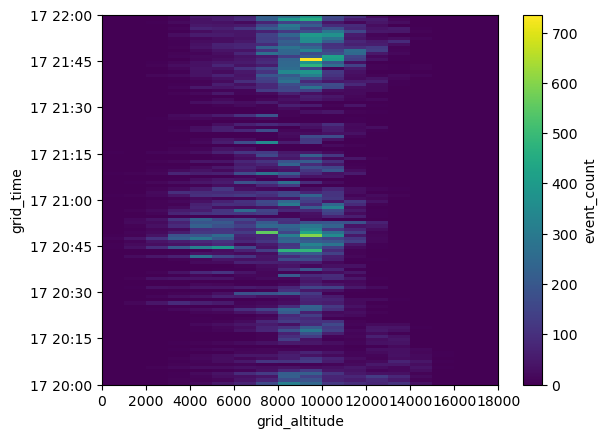

In [20]:
dsg.event_count.sum(dim=['grid_x', 'grid_y']).plot()

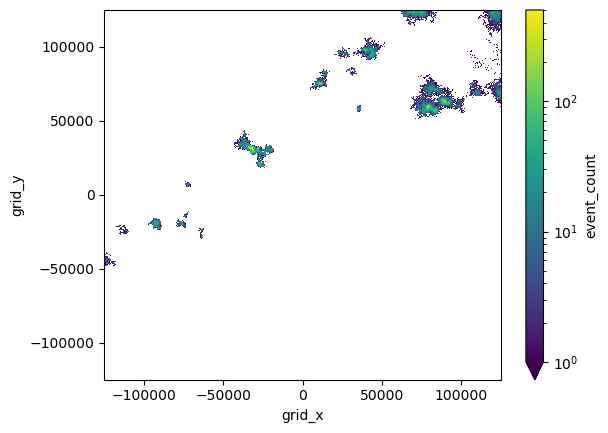

In [24]:

dsg.event_count.sum(dim=['grid_time', 'grid_altitude']).plot(norm=colors.LogNorm(vmin=1, vmax=500))

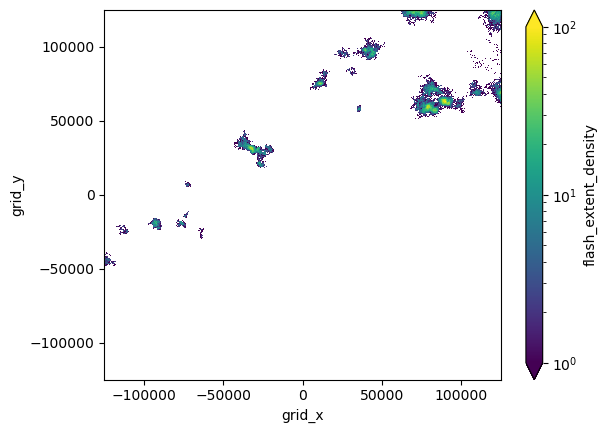

In [25]:
dsg.flash_extent_density.sum(dim=['grid_time', 'grid_altitude']).plot(norm=colors.LogNorm(vmin=1, vmax=100))